In [1]:
import torch as tr
from torch import nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipdb
from torch.utils.data import Dataset, DataLoader
from datetime import datetime

In [2]:
%pdb on
import string

class CaesarDataset(Dataset):
    def __init__(self, step, path_to_file):
        self.caesar_dict = self.generate_caesar_dictionary(step = step)
        self.stoi = self.generate_stoi()
        self.itos = self.generate_itos()
        self.dataset = self.generate_dataset(path_to_file = path_to_file)
        
    def __len__(self):
        return len(self.dataset["X"])
        
    def __getitem__(self, ix):
        return self.dataset["X"][ix], self.dataset["Y"][ix]
        
    def generate_caesar_dictionary(self, step :int) -> dict[str:str]:
        alphabet = list(string.ascii_lowercase)
        caesar_dict = {ch : alphabet[(ix + step)%len(alphabet)] for ix, ch in enumerate(alphabet)}
        return caesar_dict
            
    def word_to_caesar(self, word :str) -> str:
        encoded = [self.caesar_dict[ch] for ch in word]
        encoded = "".join(encoded)
        return encoded
    
    def generate_stoi(self):
        alphabet = list(string.ascii_lowercase)
        stoi = {ch : ix for ix, ch in enumerate(alphabet)}
        return stoi
        
    def generate_itos(self):
        alphabet = list(string.ascii_lowercase)
        itos = {ix : ch for ix, ch in enumerate(alphabet)}
        return itos
    
    def generate_dataset(self, path_to_file: str):
        dt = pd.read_csv("unigram_freq.csv")
        words_raw = dt['word'].to_numpy()
        words = list(words_raw[type(words_raw) != float].squeeze(0))[:100]
        dataset = {"X":[], "Y":[]}
        
        for ix, word in enumerate(words):
            if word is not np.nan:
                x,y = self.word_to_caesar(word), word
                for ch in x:
                    dataset["X"].append(self.stoi[ch])
                for ch in y:
                    dataset["Y"].append(self.stoi[ch])
                    
        dataset["X"] = tr.tensor(dataset["X"]).type(tr.float32).view(-1,1)
        dataset["Y"] = tr.tensor(dataset["Y"]).type(tr.long)
        return dataset

caesar_dataset = CaesarDataset(
    step = 2,
    path_to_file="unigram_freq.csv"
        )

train_amount = 0.7
val_amount = 0.5

trainn = int(len(caesar_dataset) * train_amount) 
valn = int((len(caesar_dataset) - trainn) * val_amount)
testn = len(caesar_dataset) - trainn - valn
train_data, val_data, test_data = tr.utils.data.random_split(caesar_dataset, [trainn, valn, testn])

train : DataLoader = DataLoader(train_data, batch_size = 4, shuffle = True)
val : DataLoader = DataLoader(val_data, batch_size = 16, shuffle = True)
test : DataLoader = DataLoader(test_data, batch_size = 16, shuffle = False)

Automatic pdb calling has been turned ON


In [3]:
class Trainer:
    def __init__(
        self,
        model,
        lossf, 
        opt,
        sch,
        epochn,
        device,
        train_dataloader,
        val_dataloader,
        test_dataloader
    ):
        self.model = model
        self.lossf = lossf
        self.opt = opt
        self.sch = sch
        self.epochn = epochn
        self.device = device
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.test_dataloader = test_dataloader
        
        self.lossi = []
        self.val_lossi = []
        self.test_lossi = []
        
    def train(self):
        model.to(self.device)

        for epoch in range(self.epochn):
            model.train()

            print("-"*80)
            print("| Epoch: %d |" %epoch)
            print(f"|*TRAIN*|")
            self.training_step()
            self.sch.step()
            
            model.eval()
            print(f"|*VALIDATION*|")
            self.validate()
            
        print("-"*80)
        print("-"*80)
        print("-"*80)
        print(f"|*TEST*|")
        model.eval()
        self.test()
    
    def training_step(self):
        local_loss = []
        infon = 5000
        for ix, (features, target) in enumerate(self.train_dataloader):
            if ix % infon == 0:
                b_ts = datetime.now()
            
            opt.zero_grad()
            
            features = features.to(self.device)
            pred = self.model(features)
            target = target.to(self.device)
            
            loss = lossf(pred, target)
            loss.backward()
            opt.step()

            self.lossi.append(loss.item())
            local_loss.append(loss.item())
            
            if ix % infon == 0:
                local_loss = tr.tensor(local_loss)
                e_ts = datetime.now()
            
                print(f"| train batch time: {e_ts - b_ts} |")
                print(f"| train batch mean loss: {tr.mean(local_loss)} |")
                local_loss = []

    
    def validate(self):
        local_loss = []
        b_ts = datetime.now()
                
        with tr.no_grad():
            for features, target in self.val_dataloader:
                features = features.to(self.device)
                pred = self.model(features)
                target = target.to(self.device)
                
                loss = lossf(pred, target)
                self.val_lossi.append(loss)
                local_loss.append(loss)
        local_loss = tr.tensor(local_loss)
        e_ts = datetime.now()
        print(f"|val time: {e_ts - b_ts}|")
        print(f"| val mean loss: {tr.mean(local_loss)} |")
    
            
    def test(self):
        b_ts = datetime.now()
        with tr.no_grad():
            for features, target in self.test_dataloader:
 
                features = features.to(self.device)
                pred = self.model(features)
                target = target.to(self.device)
                
                loss = lossf(pred, target)

                self.test_lossi.append(loss)
                
        local_loss = tr.tensor(self.test_lossi)
        e_ts = datetime.now()
        print(f"test time: {e_ts - b_ts}")
        print(f"| test mean loss: {tr.mean(local_loss)} |")
                
    def get_metadata(self):
        return self.lossi, self.val_lossi, self.test_lossi

In [4]:
%pdb off
q = tr.randn(3)
tr.stack((q,q),)
tr.mul(q,q) + tr.mul(q,q)

Automatic pdb calling has been turned OFF


tensor([0.1922, 0.9857, 1.3951])

In [5]:
%pdb on

class LSTMClassifier(nn.Module):
    def __init__(self, classn, embsize, innern = 16):
        super().__init__()
        self.embsize = embsize
        self.innern = innern
        self.classn = classn
        
        self.inp = nn.Linear(embsize, innern)
        self.sig = nn.Sigmoid()
        self.tanh = nn.Tanh()

        self.i_t_sub_lin_x_t = nn.Linear(innern, innern)
        self.i_t_sub_lin_h_t = nn.Linear(innern, innern)
        
        self.f_t_sub_lin_x_t = nn.Linear(innern, innern)
        self.f_t_sub_lin_h_t = nn.Linear(innern, innern)
        
        self.g_t_sub_lin_x_t = nn.Linear(innern, innern)
        self.g_t_sub_lin_h_t = nn.Linear(innern, innern)
        
        self.o_t_sub_lin_x_t = nn.Linear(innern, innern)
        self.o_t_sub_lin_h_t = nn.Linear(innern, innern)

        
        self.out = nn.Linear(innern, classn)
        self.sf = nn.Softmax(dim=1)
        
    def forward(self, X):
        out_states = []
        for ix in range(X.shape[0]):
            x = X[ix]
            
            in_l = self.inp(x)
            c_t = tr.randn(in_l.shape) # init for "long" memory
            h_t = tr.randn(in_l.shape) # init for previous step result
            
            i_t = self.sig(
                self.i_t_sub_lin_x_t(in_l) + self.i_t_sub_lin_x_t(h_t)
            ) #input
            
            f_t = self.sig(
                self.f_t_sub_lin_x_t(in_l) + self.f_t_sub_lin_x_t(h_t)
            ) #forget
            
            g_t = self.tanh(
                self.g_t_sub_lin_x_t(in_l) + self.g_t_sub_lin_x_t(h_t)
            ) #cell gate
            
            o_t = self.sig(
                self.o_t_sub_lin_x_t(in_l) + self.o_t_sub_lin_x_t(h_t)
            ) #output gate
            
            c_t = tr.mul(f_t, c_t) + tr.mul(i_t, g_t) #cell state 
            h_t = tr.mul(o_t, self.tanh(c_t)) #hidden state
            
            sub_out = self.out(h_t)
            out_states.append(sub_out)
            
        out_raw = tr.stack(out_states)
        out = self.sf(out_raw)
        return out

classn = len(caesar_dataset.caesar_dict)
emb_size = 1
fan_in, fan_out = emb_size, classn
LSTM = LSTMClassifier(
    classn = classn,
    embsize = 1,
)

Automatic pdb calling has been turned ON


In [6]:
%pdb on
model = LSTM
epochn = 10
lr = 1e-4

lossf = nn.CrossEntropyLoss()
opt = tr.optim.RMSprop(model.parameters(), lr = lr)
sch = tr.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer=opt, T_0=10)

device = tr.device("cuda") if tr.cuda.is_available() else tr.device("cpu")

train_dataloader = train 
val_dataloader = val
test_dataloader =test


config = {
    "model":model,
    "lossf":lossf,
    "opt":opt,
    "sch":sch,
    "epochn":epochn,
    "device":device,
    "train_dataloader":train_dataloader,
    "val_dataloader":val_dataloader,
    "test_dataloader":test_dataloader,
}
         
trainer = Trainer(**config)
trainer.train()

Automatic pdb calling has been turned ON
--------------------------------------------------------------------------------
| Epoch: 0 |
|*TRAIN*|
| train batch time: 0:00:00.004885 |
| train batch mean loss: 3.25362229347229 |
|*VALIDATION*|
|val time: 0:00:00.012574|
| val mean loss: 3.254688262939453 |
--------------------------------------------------------------------------------
| Epoch: 1 |
|*TRAIN*|
| train batch time: 0:00:00.003984 |
| train batch mean loss: 3.2542572021484375 |
|*VALIDATION*|
|val time: 0:00:00.013521|
| val mean loss: 3.2538392543792725 |
--------------------------------------------------------------------------------
| Epoch: 2 |
|*TRAIN*|
| train batch time: 0:00:00.003722 |
| train batch mean loss: 3.2615225315093994 |
|*VALIDATION*|
|val time: 0:00:00.012511|
| val mean loss: 3.2542073726654053 |
--------------------------------------------------------------------------------
| Epoch: 3 |
|*TRAIN*|
| train batch time: 0:00:00.004669 |
| train batch mean l

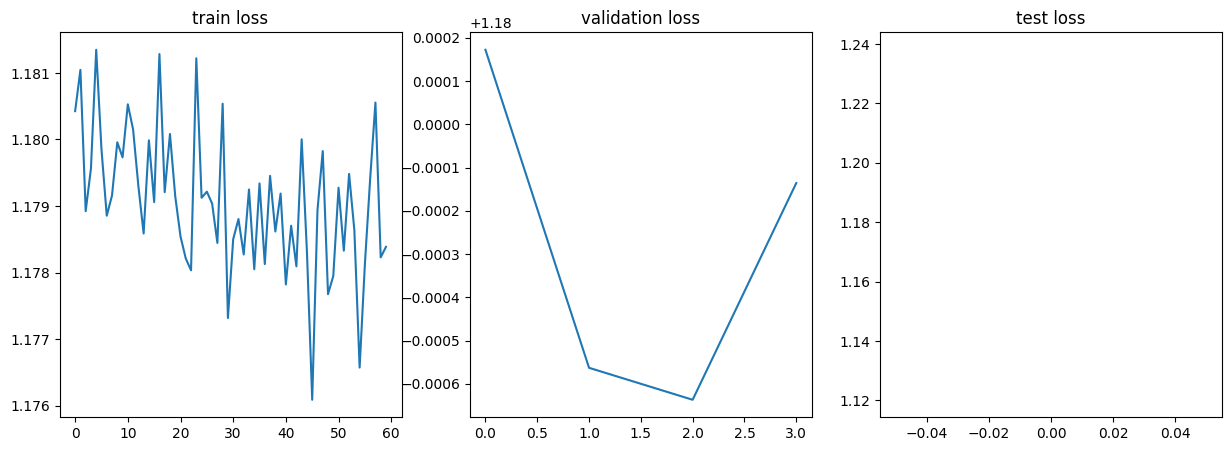

In [7]:
lossi, val_lossi, test_lossi = trainer.get_metadata()
fig, ax = plt.subplots(1,3, figsize=(15,5))

def reduce_verbose(loss, aggr_step):
    sub_loss = []
    for ix in range(0, len(loss), aggr_step):
        sub_loss.append(tr.mean(loss[ix: ix + 10]).item())
    return tr.tensor(sub_loss)
    
LOSS = [lossi, val_lossi, test_lossi]
for ix, loss in enumerate(LOSS):
    LOSS[ix] = tr.tensor(loss)
    LOSS[ix] = tr.log(LOSS[ix])
    LOSS[ix] = reduce_verbose(LOSS[ix], aggr_step=10)
    
ax[0].plot(LOSS[0])
ax[0].set_title("train loss")
ax[1].plot(LOSS[1])
ax[1].set_title("validation loss")
ax[2].plot(LOSS[2])
ax[2].set_title("test loss")
plt.show();

In [8]:
def predict_word(check):
    caesar_dataset.word_to_caesar(check)
    enc_check = tr.tensor([caesar_dataset.stoi[ch] for ch in check]).view(-1,1).type(tr.float32)
    
    raw_res = model(enc_check)
    model_word = []
    for ix in tr.max(raw_res, dim=1).indices:
        model_word.append( caesar_dataset.itos[ix.item()] )
    return "".join(model_word)

word = "check"
enc  = caesar_dataset.word_to_caesar(word)
print("Encoded: " + enc)
print("Meaning: " + word)
print("Pred Meaning: " + predict_word(enc))

Encoded: ejgem
Meaning: check
Pred Meaning: eeeei
